In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util
import json
import pyodbc


c:\Users\DanukaDilshanRathnay\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_q=pd.read_excel('C://Users//DanukaDilshanRathnay//Desktop//AI-Driven-Job-Role-Fit-Prediction//Merge_data_new4.xlsx')

In [3]:
df_q.head()

,EmployeeCode,Technical Score_JD,Programming Score_JD,Soft Score_with_JD,Education_match_Score_with_JD,Gender,Age,Department,JobCategory,ProficiencyLevel,...,Number of Goal Assigned,Number of Goals Achieved,Final Score,Goals Score,Competency Score,Cultural Value Score,Additional Accomplishment Score,Potential Assessment Score,Trait Assessment Score,Projects Completed
0,EMP9000,0.075417,0.000000,0.493587,0.708484,Female,26,Software Engineering,QA,Junior,...,4,2,44.47,50.00,27.11,75.88,2.63,68.77,74.89,"Security Vulnerability Detection, End-to-End T..."
1,EMP9001,0.088751,0.000000,0.354090,0.631961,Male,23,Software Engineering,UI/UX Designer,Junior,...,14,5,46.27,35.71,25.34,79.76,8.69,86.84,75.05,"AR-Based Onboarding Flows, Minimalist UI for P..."
2,EMP9002,0.024108,0.255731,0.450265,0.644765,Female,36,Software Engineering,Backend Developer,Mid-Level,...,4,1,61.72,25.00,41.18,71.83,5.81,97.21,90.59,"Serverless API Development, High-Performance C..."
3,EMP9004,0.514297,0.722849,0.379506,0.614774,Male,41,Data and AI,Data Scientist,Senior,...,14,11,52.22,78.57,18.26,76.86,7.08,73.13,90.32,"Predictive Maintenance for Manufacturing, AI-P..."
4,EMP9005,0.229454,0.787505,0.420458,0.644765,Female,33,Data and AI,Data Engineer,Mid-Level,...,6,1,38.02,16.67,31.48,93.42,1.63,92.72,84.34,"Automated Data Quality Framework, Data Warehou..."


In [4]:
# pip install sentence_transformers,tf-keras



In [5]:
# pip install pyodbc


### meassure the similarity between job descrption and Employees

In [6]:
server = 'DESKTOP-2DSGQFI'
driver = '{ODBC Driver 17 for SQL Server}'
default_database = 'ABC_Company'
connection_string = f"DRIVER={driver};SERVER={server};DATABASE={default_database};Trusted_Connection=yes"

conn = pyodbc.connect(connection_string, autocommit=True)
cursor = conn.cursor()
print("Connected to SQL Server")
def get_jd_data():
    query = "SELECT details FROM JD_Collection WHERE possition='Data Scientist'"
    return pd.read_sql(query, conn)

# Fetch Job Description data
df_jd = get_jd_data()
conn.close()

Connected to SQL Server


C:\Users\DanukaDilshanRathnay\AppData\Local\Temp\ipykernel_18380\3516608023.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


In [7]:
# Ensure job descriptions are extracted correctly
job_descriptions = df_jd['details'].tolist()
df1 = pd.read_excel('C://Users//DanukaDilshanRathnay//Desktop//AI-Driven-Job-Role-Fit-Prediction//com//Employee4.xlsx')


columns_to_use = [
    'EmployeeCode', 'FullName', 'Gender', 'Age',"Department",
    'JobCategory', 'ProficiencyLevel', 'Education Qualifications',
    'Professional Qualifications', 'Total Experience in Years',
    'List of Technical Skills', 'List of Programming Skills',
    'List of Software Skills', 'List of Soft Skills', 'Projects Completed'
]
df1 = df1[columns_to_use]


df1.fillna("", inplace=True)


def format_employee_profile(row):
    profile_dict = {
        # "Full Name": row['FullName'],
        # "Age": row['Age'],
        "Department": row['Department'],
        "Job Category": row['JobCategory'],
        "Proficiency Level": row['ProficiencyLevel'],
        "Education": row['Education Qualifications'],
        "Professional Certifications": row['Professional Qualifications'],
        "Total Experience (Years)": row['Total Experience in Years'],
        "Technical Skills": row['List of Technical Skills'],
        "Programming Skills": row['List of Programming Skills'],
        "Software Skills": row['List of Software Skills'],
        "Soft Skills": row['List of Soft Skills'],
        "Projects Completed": row['Projects Completed']
    }
    return json.dumps(profile_dict, ensure_ascii=False, indent=4)

# Apply formatting function to generate textual profiles
df1["EmployeeProfileText"] = df1.apply(format_employee_profile, axis=1)


In [8]:
# Load the SentenceTransformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Compute embeddings for employee profiles
employee_embeddings = model.encode(df1['EmployeeProfileText'].tolist(), convert_to_tensor=True)

# Compute similarity scores with each job description
similarity_scores = []
for emp_emb in employee_embeddings:
    scores = [util.cos_sim(emp_emb, model.encode(jd, convert_to_tensor=True)).item() for jd in job_descriptions]
    similarity_scores.append(max(scores))  # Store the highest similarity score

# Store similarity scores in the dataframe
df1['JD match Score'] = similarity_scores
df1.to_excel("matchscore.xlsx",index=False)

In [9]:
df_jdmatch=df1[["EmployeeCode",'JD match Score']]
df_jdmatch.head()

,EmployeeCode,JD match Score
0,EMP9449,0.634497
1,EMP9597,0.433618
2,EMP9205,0.340384
3,EMP9881,0.390756
4,EMP9883,0.542990


In [10]:
# add jd match score to similarity messure file

# df = pd.merge(df_q, df_jdmatch, on="EmployeeCode")
df=df_q

In [11]:
df.head()

,EmployeeCode,Technical Score_JD,Programming Score_JD,Soft Score_with_JD,Education_match_Score_with_JD,Gender,Age,Department,JobCategory,ProficiencyLevel,...,Number of Goal Assigned,Number of Goals Achieved,Final Score,Goals Score,Competency Score,Cultural Value Score,Additional Accomplishment Score,Potential Assessment Score,Trait Assessment Score,Projects Completed
0,EMP9000,0.075417,0.000000,0.493587,0.708484,Female,26,Software Engineering,QA,Junior,...,4,2,44.47,50.00,27.11,75.88,2.63,68.77,74.89,"Security Vulnerability Detection, End-to-End T..."
1,EMP9001,0.088751,0.000000,0.354090,0.631961,Male,23,Software Engineering,UI/UX Designer,Junior,...,14,5,46.27,35.71,25.34,79.76,8.69,86.84,75.05,"AR-Based Onboarding Flows, Minimalist UI for P..."
2,EMP9002,0.024108,0.255731,0.450265,0.644765,Female,36,Software Engineering,Backend Developer,Mid-Level,...,4,1,61.72,25.00,41.18,71.83,5.81,97.21,90.59,"Serverless API Development, High-Performance C..."
3,EMP9004,0.514297,0.722849,0.379506,0.614774,Male,41,Data and AI,Data Scientist,Senior,...,14,11,52.22,78.57,18.26,76.86,7.08,73.13,90.32,"Predictive Maintenance for Manufacturing, AI-P..."
4,EMP9005,0.229454,0.787505,0.420458,0.644765,Female,33,Data and AI,Data Engineer,Mid-Level,...,6,1,38.02,16.67,31.48,93.42,1.63,92.72,84.34,"Automated Data Quality Framework, Data Warehou..."


In [12]:
df=df[df["Department"]=="Data and AI"]
df.head()

,EmployeeCode,Technical Score_JD,Programming Score_JD,Soft Score_with_JD,Education_match_Score_with_JD,Gender,Age,Department,JobCategory,ProficiencyLevel,...,Number of Goal Assigned,Number of Goals Achieved,Final Score,Goals Score,Competency Score,Cultural Value Score,Additional Accomplishment Score,Potential Assessment Score,Trait Assessment Score,Projects Completed
3,EMP9004,0.514297,0.722849,0.379506,0.614774,Male,41,Data and AI,Data Scientist,Senior,...,14,11,52.22,78.57,18.26,76.86,7.08,73.13,90.32,"Predictive Maintenance for Manufacturing, AI-P..."
4,EMP9005,0.229454,0.787505,0.420458,0.644765,Female,33,Data and AI,Data Engineer,Mid-Level,...,6,1,38.02,16.67,31.48,93.42,1.63,92.72,84.34,"Automated Data Quality Framework, Data Warehou..."
6,EMP9009,0.413824,0.722849,0.586283,0.653466,Male,35,Data and AI,Data Scientist,Mid-Level,...,3,3,61.98,100.00,37.78,95.03,8.01,97.17,54.92,"Ethical AI Bias Detection, GenAI-Powered Custo..."
9,EMP9015,0.451817,0.539208,0.558488,0.661025,Male,42,Data and AI,Data Scientist,Senior,...,15,3,47.42,20.00,38.64,73.40,5.71,95.48,50.31,"Predictive Maintenance for Manufacturing, GenA..."
11,EMP9021,0.162984,0.539208,0.382562,0.760446,Male,59,Data and AI,Data Analyst,Expert,...,7,1,46.02,14.29,35.64,80.67,2.63,60.49,79.95,"Sustainability Metrics Dashboard, Sales Foreca..."


In [13]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(df,test_size=0.2,random_state=123)
print("Train Size:",train_df.shape)
print("Test Size:",test_df.shape)

Train Size: (192, 29)
Test Size: (48, 29)


In [14]:
train_df.columns

Index(['EmployeeCode', 'Technical Score_JD', 'Programming Score_JD',
       'Soft Score_with_JD', 'Education_match_Score_with_JD', 'Gender', 'Age',
       'Department', 'JobCategory', 'ProficiencyLevel',
       'Education Qualifications', 'Professional Qualifications',
       'Years of Experience in this Company', 'List of Software Skills', 'KPI',
       'Absentism Rate', 'Employee Satisfaction Score',
       'Experience in Years Previous Positions', 'Total Experience in Years',
       'Number of Goal Assigned', 'Number of Goals Achieved', 'Final Score',
       'Goals Score', 'Competency Score', 'Cultural Value Score',
       'Additional Accomplishment Score', 'Potential Assessment Score',
       'Trait Assessment Score', 'Projects Completed'],
      dtype='object')

In [15]:
un_col=['Gender','Department', 'JobCategory', 'ProficiencyLevel',
       'Education Qualifications', 'Professional Qualifications','Final Score','Age','List of Software Skills','Number of Goal Assigned', 'Number of Goals Achieved','Projects Completed',"Total Experience in Years","Absentism Rate"]
df_n=train_df.drop(columns=un_col)

In [16]:
df_n.head()

,EmployeeCode,Technical Score_JD,Programming Score_JD,Soft Score_with_JD,Education_match_Score_with_JD,Years of Experience in this Company,KPI,Employee Satisfaction Score,Experience in Years Previous Positions,Goals Score,Competency Score,Cultural Value Score,Additional Accomplishment Score,Potential Assessment Score,Trait Assessment Score
263,EMP9549,0.448364,0.787505,0.434668,0.538119,8,92.17,71.79,11,75.00,32.66,92.03,9.18,80.15,90.15
191,EMP9425,0.114968,0.536558,0.590693,0.638099,3,59.92,80.46,7,30.77,21.20,74.21,4.07,70.46,77.21
19,EMP9041,0.464104,0.787505,0.525904,0.537262,14,84.81,63.71,0,50.00,38.88,64.06,7.92,90.58,74.11
422,EMP9852,0.113330,0.787505,0.395103,0.635009,21,88.29,80.56,6,40.00,33.61,92.41,1.35,73.43,96.93
314,EMP9640,0.229454,1.000000,0.354829,0.603108,1,84.41,77.01,11,100.00,36.29,70.48,8.82,94.59,59.82


In [17]:
# df_n["Goal Complete Ratio"] = df_n['Number of Goals Achieved'] / df_n['Number of Goal Assigned']

# df_n.drop(columns=['Number of Goal Assigned', 'Number of Goals Achieved'], inplace=True)


In [18]:
df_n.head()

,EmployeeCode,Technical Score_JD,Programming Score_JD,Soft Score_with_JD,Education_match_Score_with_JD,Years of Experience in this Company,KPI,Employee Satisfaction Score,Experience in Years Previous Positions,Goals Score,Competency Score,Cultural Value Score,Additional Accomplishment Score,Potential Assessment Score,Trait Assessment Score
263,EMP9549,0.448364,0.787505,0.434668,0.538119,8,92.17,71.79,11,75.00,32.66,92.03,9.18,80.15,90.15
191,EMP9425,0.114968,0.536558,0.590693,0.638099,3,59.92,80.46,7,30.77,21.20,74.21,4.07,70.46,77.21
19,EMP9041,0.464104,0.787505,0.525904,0.537262,14,84.81,63.71,0,50.00,38.88,64.06,7.92,90.58,74.11
422,EMP9852,0.113330,0.787505,0.395103,0.635009,21,88.29,80.56,6,40.00,33.61,92.41,1.35,73.43,96.93
314,EMP9640,0.229454,1.000000,0.354829,0.603108,1,84.41,77.01,11,100.00,36.29,70.48,8.82,94.59,59.82


In [19]:
# from sklearn.model_selection import train_test_split
# train_df,test_df=train_test_split(df_n,test_size=0.2,random_state=123)
# print("Train Size:",train_df.shape)
# print("Test Size:",test_df.shape)

In [20]:
# train_df.head()

In [21]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, 263 to 231
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   EmployeeCode                            192 non-null    object 
 1   Technical Score_JD                      192 non-null    float64
 2   Programming Score_JD                    192 non-null    float64
 3   Soft Score_with_JD                      192 non-null    float64
 4   Education_match_Score_with_JD           192 non-null    float64
 5   Years of Experience in this Company     192 non-null    int64  
 6   KPI                                     192 non-null    float64
 7   Employee Satisfaction Score             192 non-null    float64
 8   Experience in Years Previous Positions  192 non-null    int64  
 9   Goals Score                             192 non-null    float64
 10  Competency Score                        192 non-null    float64
 

In [22]:
employee_ids = df_n['EmployeeCode']
df_di=df_n.drop(columns=["EmployeeCode"])


In [23]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sd=StandardScaler()
mn=MinMaxScaler()

In [24]:
df_con=sd.fit_transform(df_di)
df_con=pd.DataFrame(df_con,columns=df_di.columns)
df_con.head()


,Technical Score_JD,Programming Score_JD,Soft Score_with_JD,Education_match_Score_with_JD,Years of Experience in this Company,KPI,Employee Satisfaction Score,Experience in Years Previous Positions,Goals Score,Competency Score,Cultural Value Score,Additional Accomplishment Score,Potential Assessment Score,Trait Assessment Score
0,1.142729,0.412252,0.380676,-1.775962,-0.174198,1.167505,-0.650547,0.257557,0.762479,0.088409,1.118293,1.431468,0.317102,1.042114
1,-1.097564,-0.726103,2.033400,0.068012,-0.853995,-1.051686,0.123796,-0.252247,-0.575099,-1.183099,-0.492937,-0.315676,-0.315612,0.136168
2,1.248495,0.412252,1.347111,-1.791762,0.641559,0.661048,-1.372196,-1.144404,0.006444,0.778529,-1.410670,1.000666,0.998134,-0.080867
3,-1.108566,0.412252,-0.038425,0.011034,1.593275,0.900514,0.132727,-0.379698,-0.295971,0.193813,1.152652,-1.245663,-0.121684,1.516791
4,-0.328261,1.376179,-0.465044,-0.577332,-1.125914,0.633523,-0.184334,0.257557,1.518515,0.491164,-0.830193,1.308382,1.259970,-1.081328


In [25]:
df_con.isnull().sum()

Technical Score_JD                        0
Programming Score_JD                      0
Soft Score_with_JD                        0
Education_match_Score_with_JD             0
Years of Experience in this Company       0
KPI                                       0
Employee Satisfaction Score               0
Experience in Years Previous Positions    0
Goals Score                               0
Competency Score                          0
Cultural Value Score                      0
Additional Accomplishment Score           0
Potential Assessment Score                0
Trait Assessment Score                    0
dtype: int64

In [26]:
# pip install factor_analyzer

## Principal component Analysis

In [27]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Compute KMO & Bartlett's Test
from factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(df_con)

# Display results
print(f"KMO Value: {kmo_model:.3f}")


KMO Value: 0.363


In [29]:
pca=PCA()
pca.fit(df_con)

PCA()

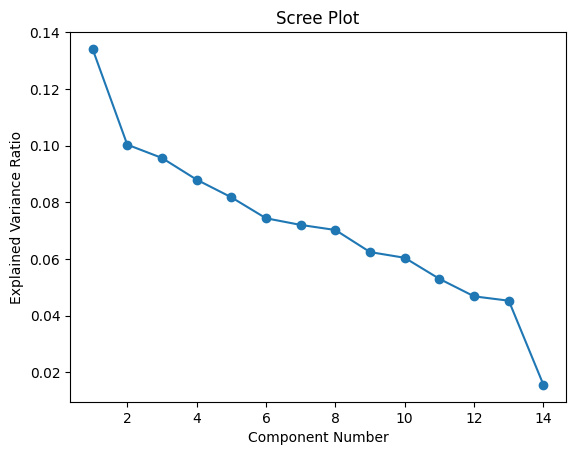

In [30]:
# Plot scree plot
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()


In [31]:
eigenvalues=pca.explained_variance_
print(eigenvalues)

[1.88708295 1.41195682 1.34589968 1.23822551 1.15066212 1.0466283
 1.01357079 0.9883691  0.87880279 0.85037341 0.74580281 0.65903567
 0.63744014 0.21944836]


In [32]:
eigenvector=pca.components_
print(eigenvector.shape)
eigen_df=pd.DataFrame(eigenvector,columns=[f'PCA{i+1}' for i in range(df_con.shape[1])])
eigen_df.head(5)

(14, 14)


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14
0,-0.171092,-0.232685,-0.094560,-0.252957,0.356820,0.364351,0.031720,0.326463,0.062616,0.618474,0.112380,0.129261,0.121427,-0.213276
1,-0.320566,-0.402127,-0.196271,-0.067593,-0.135505,-0.343213,-0.257826,0.276874,-0.001601,-0.182470,0.490872,-0.096595,0.256815,0.252215
2,0.418588,0.409969,-0.161357,0.068726,-0.249385,0.284580,-0.344758,0.291651,0.021492,0.241448,0.133528,-0.205972,0.108472,0.384805
3,0.215718,0.039677,-0.094953,-0.268152,0.044333,-0.157251,-0.090458,0.062380,0.518310,-0.084314,0.118183,0.615840,-0.369022,0.164455
4,0.356708,-0.013965,0.236557,-0.259855,0.116724,-0.171700,-0.486223,-0.145487,-0.133613,-0.066815,-0.082764,0.209113,0.528968,-0.309345


Number of components with eigenvalue > 1: 7


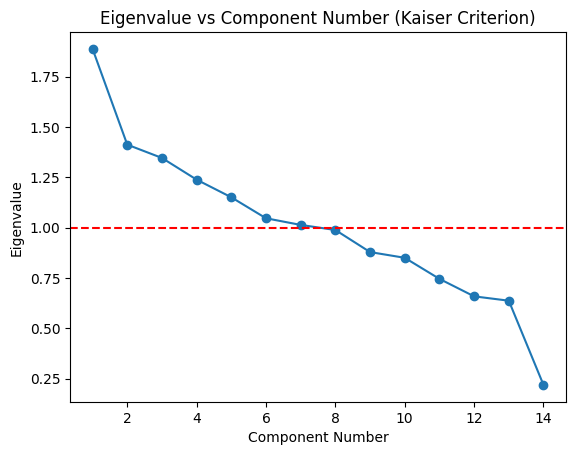

In [33]:
n_components = np.sum(eigenvalues > 1)
print(f"Number of components with eigenvalue > 1: {n_components}")

# Optional: Plot the eigenvalues to visualize the decision
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.axhline(y=1, color='r', linestyle='--')  # Draw line at eigenvalue = 1
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue vs Component Number (Kaiser Criterion)')
plt.show()

In [34]:
#total variabtion explain by first 8 components

total_va=(eigenvalues[:n_components].sum()/eigenvalues.sum())*100
print(total_va)

64.6190103764442


In [35]:
selected_eigenvectors = pd.DataFrame(eigenvector[:,:n_components], columns=[f'PCA{i+1}' for i in range(n_components)])
selected_eigenvectors.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7
0,-0.171092,-0.232685,-0.094560,-0.252957,0.356820,0.364351,0.031720
1,-0.320566,-0.402127,-0.196271,-0.067593,-0.135505,-0.343213,-0.257826
2,0.418588,0.409969,-0.161357,0.068726,-0.249385,0.284580,-0.344758
3,0.215718,0.039677,-0.094953,-0.268152,0.044333,-0.157251,-0.090458
4,0.356708,-0.013965,0.236557,-0.259855,0.116724,-0.171700,-0.486223


In [36]:
selected_eigenvectors.shape

(14, 7)

#### To normilize the eigen vetors (ev/sqrt(corr.lamda))

In [37]:
selected=eigenvalues[:n_components]
print(selected)

[1.88708295 1.41195682 1.34589968 1.23822551 1.15066212 1.0466283
 1.01357079]


In [38]:
Normalize_eigenvector = pd.DataFrame(selected_eigenvectors / np.sqrt(selected))
Normalize_eigenvector.head()


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7
0,-0.124547,-0.195820,-0.081508,-0.227325,0.332641,0.356142,0.031507
1,-0.233358,-0.338417,-0.169180,-0.060744,-0.126322,-0.335481,-0.256094
2,0.304713,0.345017,-0.139085,0.061762,-0.232486,0.278168,-0.342442
3,0.157033,0.033391,-0.081847,-0.240980,0.041329,-0.153708,-0.089851
4,0.259668,-0.011752,0.203905,-0.233523,0.108814,-0.167832,-0.482957


In [39]:
## make eigen values as fraction

selected_ra=eigenvalues[:n_components]/eigenvalues[:n_components].sum()
print(selected_ra)

[0.20750797 0.15526201 0.14799822 0.13615812 0.12652945 0.11508965
 0.11145457]


In [40]:
nor_ve=eigenvector[:,:n_components]/ np.sqrt(selected)


In [41]:
eigen_loadings = pd.DataFrame(nor_ve, index=df_con.columns, columns=[f'pca{i+1}' for i in range(n_components)])
eigen_loadings.head(21)

,pca1,pca2,pca3,pca4,pca5,pca6,pca7
Technical Score_JD,-0.124547,-0.195820,-0.081508,-0.227325,0.332641,0.356142,0.031507
Programming Score_JD,-0.233358,-0.338417,-0.169180,-0.060744,-0.126322,-0.335481,-0.256094
Soft Score_with_JD,0.304713,0.345017,-0.139085,0.061762,-0.232486,0.278168,-0.342442
Education_match_Score_with_JD,0.157033,0.033391,-0.081847,-0.240980,0.041329,-0.153708,-0.089851
Years of Experience in this Company,0.259668,-0.011752,0.203905,-0.233523,0.108814,-0.167832,-0.482957
KPI,-0.068422,0.035405,0.499907,0.195916,-0.403434,0.114389,0.184908
Employee Satisfaction Score,0.103639,0.168443,0.382642,-0.369338,0.144175,-0.353608,0.353959
Experience in Years Previous Positions,0.096499,0.181679,-0.054258,0.228877,0.496759,-0.180566,0.207680
Goals Score,0.147478,-0.004385,-0.303517,0.213275,-0.003388,-0.418832,0.164474
Competency Score,-0.048620,-0.131866,0.313088,0.530649,0.294403,-0.116375,-0.296042


In [42]:
def generate_pca_equation_dict(loadings_array, feature_names):
    # Convert to DataFrame for ease of processing
    loading_df = pd.DataFrame(loadings_array, columns=[f"PCA{i+1}" for i in range(loadings_array.shape[1])], index=feature_names)

    pca_equation_dict = {}

    # Debugging prints
    # print("Loading DataFrame:\n", loading_df.head())

    # Iterate through each PCA component
    for pca in loading_df.columns:
        terms = []
        for feature, loading in loading_df[pca].items():
            terms.append(f"{loading:.5f} * df_di['{feature}']")  # Format coefficients
        equation = " + ".join(terms)
        pca_equation_dict[pca] = equation

    return pca_equation_dict


# Generate the equation dictionary
feature_names = eigen_loadings.index  # Ensure correct feature names
pca_equations = generate_pca_equation_dict(eigen_loadings.values, feature_names)

# Print the generated PCA equations
for pca, eq in pca_equations.items():
    print(f"{pca}= {eq}\n")



PCA1= -0.12455 * df_di['Technical Score_JD'] + -0.23336 * df_di['Programming Score_JD'] + 0.30471 * df_di['Soft Score_with_JD'] + 0.15703 * df_di['Education_match_Score_with_JD'] + 0.25967 * df_di['Years of Experience in this Company'] + -0.06842 * df_di['KPI'] + 0.10364 * df_di['Employee Satisfaction Score'] + 0.09650 * df_di['Experience in Years Previous Positions'] + 0.14748 * df_di['Goals Score'] + -0.04862 * df_di['Competency Score'] + 0.02962 * df_di['Cultural Value Score'] + 0.46929 * df_di['Additional Accomplishment Score'] + 0.03197 * df_di['Potential Assessment Score'] + -0.06354 * df_di['Trait Assessment Score']

PCA2= -0.19582 * df_di['Technical Score_JD'] + -0.33842 * df_di['Programming Score_JD'] + 0.34502 * df_di['Soft Score_with_JD'] + 0.03339 * df_di['Education_match_Score_with_JD'] + -0.01175 * df_di['Years of Experience in this Company'] + 0.03540 * df_di['KPI'] + 0.16844 * df_di['Employee Satisfaction Score'] + 0.18168 * df_di['Experience in Years Previous Positions

In [43]:
suitability_equations = []

for i, (pca, equation) in enumerate(pca_equations.items()):
    if i < len(selected_ra):
        suitability = f"{selected_ra[i]:.5f} *  ({equation})"
        suitability_equations.append(suitability)
        

# Combine all equations into one final equation
final_equation = " + ".join(suitability_equations)

print("Final Suitability Equation:\n", final_equation)



Final Suitability Equation:
 0.20751 *  (-0.12455 * df_di['Technical Score_JD'] + -0.23336 * df_di['Programming Score_JD'] + 0.30471 * df_di['Soft Score_with_JD'] + 0.15703 * df_di['Education_match_Score_with_JD'] + 0.25967 * df_di['Years of Experience in this Company'] + -0.06842 * df_di['KPI'] + 0.10364 * df_di['Employee Satisfaction Score'] + 0.09650 * df_di['Experience in Years Previous Positions'] + 0.14748 * df_di['Goals Score'] + -0.04862 * df_di['Competency Score'] + 0.02962 * df_di['Cultural Value Score'] + 0.46929 * df_di['Additional Accomplishment Score'] + 0.03197 * df_di['Potential Assessment Score'] + -0.06354 * df_di['Trait Assessment Score']) + 0.15526 *  (-0.19582 * df_di['Technical Score_JD'] + -0.33842 * df_di['Programming Score_JD'] + 0.34502 * df_di['Soft Score_with_JD'] + 0.03339 * df_di['Education_match_Score_with_JD'] + -0.01175 * df_di['Years of Experience in this Company'] + 0.03540 * df_di['KPI'] + 0.16844 * df_di['Employee Satisfaction Score'] + 0.18168 * df

In [44]:
train_df["Suitability_score"]=eval(final_equation)

In [45]:
train_df.head()

,EmployeeCode,Technical Score_JD,Programming Score_JD,Soft Score_with_JD,Education_match_Score_with_JD,Gender,Age,Department,JobCategory,ProficiencyLevel,...,Number of Goals Achieved,Final Score,Goals Score,Competency Score,Cultural Value Score,Additional Accomplishment Score,Potential Assessment Score,Trait Assessment Score,Projects Completed,Suitability_score
263,EMP9549,0.448364,0.787505,0.434668,0.538119,Female,41,Data and AI,Data Scientist,Senior,...,6,62.86,75.00,32.66,92.03,9.18,80.15,90.15,"AI-Powered Fraud Detection, Predictive Mainten...",11.593977
191,EMP9425,0.114968,0.536558,0.590693,0.638099,Female,32,Data and AI,Data Analyst,Mid-Level,...,4,45.48,30.77,21.20,74.21,4.07,70.46,77.21,"Churn Prediction for Subscription Services, Cu...",9.174761
19,EMP9041,0.464104,0.787505,0.525904,0.537262,Male,36,Data and AI,Data Scientist,Mid-Level,...,2,51.99,50.00,38.88,64.06,7.92,90.58,74.11,"Ethical AI Bias Detection, Predictive Maintena...",10.187610
422,EMP9852,0.113330,0.787505,0.395103,0.635009,Female,49,Data and AI,Data Engineer,Senior,...,6,52.74,40.00,33.61,92.41,1.35,73.43,96.93,"Data Warehouse Optimization, Data Catalog and ...",10.437627
314,EMP9640,0.229454,1.000000,0.354829,0.603108,Male,34,Data and AI,Data Engineer,Mid-Level,...,4,56.64,100.00,36.29,70.48,8.82,94.59,59.82,"Data Mesh Implementation, Data Warehouse Optim...",13.871330


In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df['Suitability Score Scaled'] = scaler.fit_transform(train_df[['Suitability_score']])
train_df.to_excel("aa.xlsx",index=False)

In [47]:
#test set
def generate_pca_equation_dict(loadings_array, feature_names):
    # Convert to DataFrame for ease of processing
    loading_df = pd.DataFrame(loadings_array, columns=[f"PCA{i+1}" for i in range(loadings_array.shape[1])], index=feature_names)

    pca_equation_dict = {}

    # Debugging prints
    # print("Loading DataFrame:\n", loading_df.head())

    # Iterate through each PCA component
    for pca in loading_df.columns:
        terms = []
        for feature, loading in loading_df[pca].items():
            terms.append(f"{loading:.5f} * test_df['{feature}']")  # Format coefficients
        equation = " + ".join(terms)
        pca_equation_dict[pca] = equation

    return pca_equation_dict


# Generate the equation dictionary
feature_names = eigen_loadings.index  # Ensure correct feature names
pca_equations1 = generate_pca_equation_dict(eigen_loadings.values, feature_names)

# Print the generated PCA equations
for pca, eq in pca_equations1.items():
    print(f"{pca}= {eq}\n")


PCA1= -0.12455 * test_df['Technical Score_JD'] + -0.23336 * test_df['Programming Score_JD'] + 0.30471 * test_df['Soft Score_with_JD'] + 0.15703 * test_df['Education_match_Score_with_JD'] + 0.25967 * test_df['Years of Experience in this Company'] + -0.06842 * test_df['KPI'] + 0.10364 * test_df['Employee Satisfaction Score'] + 0.09650 * test_df['Experience in Years Previous Positions'] + 0.14748 * test_df['Goals Score'] + -0.04862 * test_df['Competency Score'] + 0.02962 * test_df['Cultural Value Score'] + 0.46929 * test_df['Additional Accomplishment Score'] + 0.03197 * test_df['Potential Assessment Score'] + -0.06354 * test_df['Trait Assessment Score']

PCA2= -0.19582 * test_df['Technical Score_JD'] + -0.33842 * test_df['Programming Score_JD'] + 0.34502 * test_df['Soft Score_with_JD'] + 0.03339 * test_df['Education_match_Score_with_JD'] + -0.01175 * test_df['Years of Experience in this Company'] + 0.03540 * test_df['KPI'] + 0.16844 * test_df['Employee Satisfaction Score'] + 0.18168 * tes

In [48]:
suitability_equations = []

for i, (pca, equation) in enumerate(pca_equations1.items()):
    if i < len(selected_ra):
        suitability = f"{selected_ra[i]:.5f} *  ({equation})"
        suitability_equations.append(suitability)
        

# Combine all equations into one final equation
final_equation1 = " + ".join(suitability_equations)

print("Final Suitability Equation:\n", final_equation1)

Final Suitability Equation:
 0.20751 *  (-0.12455 * test_df['Technical Score_JD'] + -0.23336 * test_df['Programming Score_JD'] + 0.30471 * test_df['Soft Score_with_JD'] + 0.15703 * test_df['Education_match_Score_with_JD'] + 0.25967 * test_df['Years of Experience in this Company'] + -0.06842 * test_df['KPI'] + 0.10364 * test_df['Employee Satisfaction Score'] + 0.09650 * test_df['Experience in Years Previous Positions'] + 0.14748 * test_df['Goals Score'] + -0.04862 * test_df['Competency Score'] + 0.02962 * test_df['Cultural Value Score'] + 0.46929 * test_df['Additional Accomplishment Score'] + 0.03197 * test_df['Potential Assessment Score'] + -0.06354 * test_df['Trait Assessment Score']) + 0.15526 *  (-0.19582 * test_df['Technical Score_JD'] + -0.33842 * test_df['Programming Score_JD'] + 0.34502 * test_df['Soft Score_with_JD'] + 0.03339 * test_df['Education_match_Score_with_JD'] + -0.01175 * test_df['Years of Experience in this Company'] + 0.03540 * test_df['KPI'] + 0.16844 * test_df['Em

In [49]:
scaler = MinMaxScaler()
test_df["score"]=eval(final_equation1)
test_df['Suitability Score Scaled'] = scaler.fit_transform(test_df[['score']])

In [50]:
test_df.shape

(48, 31)

In [51]:
test_df.to_excel("test.xlsx",index=False)

In [52]:
train_df.shape

(192, 31)

In [53]:
feature_importance = np.abs(eigenvector[:n_components])  # Take absolute value for importance
overall_importance = feature_importance.sum(axis=0)  # Sum across rows (principal components)
print(overall_importance)
# Normalize to percentages
overall_importance_percentages = (overall_importance / overall_importance.sum()) *100

# Sort feature importances in descending order
sorted_indices = np.argsort(overall_importance_percentages)[::-1]  # Sort indices in descending order

# Print overall feature importance as percentages with column names in descending order
print("\nOverall Feature Importance (as %):")
for idx in sorted_indices:
    print(f"{df_con.columns[idx]}: {overall_importance_percentages[idx]:.2f}%")

[1.7190331  1.34064551 1.80756917 1.54627175 1.49018034 1.79987816
 1.75349592 1.64401284 1.46315263 1.28167056 1.22468681 1.48450609
 1.7309015  1.74859879]

Overall Feature Importance (as %):
Soft Score_with_JD: 8.20%
KPI: 8.17%
Employee Satisfaction Score: 7.96%
Trait Assessment Score: 7.94%
Potential Assessment Score: 7.86%
Technical Score_JD: 7.80%
Experience in Years Previous Positions: 7.46%
Education_match_Score_with_JD: 7.02%
Years of Experience in this Company: 6.76%
Additional Accomplishment Score: 6.74%
Goals Score: 6.64%
Programming Score_JD: 6.08%
Competency Score: 5.82%
Cultural Value Score: 5.56%


## Factor Analysis

In [54]:
from sklearn.decomposition import FactorAnalysis
num_factors =n_components  # You can adjust this number
#fa = FactorAnalysis(n_components=num_factors,rotation="varimax",random_state=42)
fa = FactorAnalysis(n_components=num_factors,random_state=42)
fa.fit(df_con)

# Step 3: Extract Factor Loadings
factor_loadings = pd.DataFrame(fa.components_.T, index=df_con.columns, columns=[f'Factor{i+1}' for i in range(num_factors)])

In [55]:
factor_loadings

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7
Technical Score_JD,-0.042411,-0.086647,0.030983,0.699435,-0.018021,-0.102935,-0.015962
Programming Score_JD,-0.064606,-0.183308,0.057544,0.390496,-0.040049,0.130763,-0.073520
Soft Score_with_JD,-0.055568,-0.016374,0.031584,0.039290,-0.006298,-0.089260,-0.183922
Education_match_Score_with_JD,-0.142387,-0.121679,0.026779,0.008850,-0.120374,0.112550,-0.055065
Years of Experience in this Company,0.386312,0.603743,0.435379,0.006555,-0.008418,0.054832,0.057636
KPI,0.626247,-0.583911,0.189524,-0.077232,0.025561,-0.004132,0.050613
Employee Satisfaction Score,0.033725,0.051552,0.096750,-0.109892,0.080268,0.199494,-0.314360
Experience in Years Previous Positions,0.356196,0.165440,-0.703307,-0.011145,0.093384,0.024379,-0.034407
Goals Score,0.035563,0.002661,-0.018764,0.034625,0.184862,-0.069797,0.086373
Competency Score,0.916261,0.092433,-0.060143,0.056757,-0.027555,0.012738,-0.023631


In [56]:
df_con.columns

Index(['Technical Score_JD', 'Programming Score_JD', 'Soft Score_with_JD',
       'Education_match_Score_with_JD', 'Years of Experience in this Company',
       'KPI', 'Employee Satisfaction Score',
       'Experience in Years Previous Positions', 'Goals Score',
       'Competency Score', 'Cultural Value Score',
       'Additional Accomplishment Score', 'Potential Assessment Score',
       'Trait Assessment Score'],
      dtype='object')

In [57]:
factor_loadings = np.abs(fa.components_.T)  # Absolute values of loadings
feature_importance_fa = np.sum(factor_loadings, axis=1)  # Sum across factors

# Create DataFrame
fa_importance_df = pd.DataFrame({'Feature': df_con.columns, 'Importance': feature_importance_fa})
fa_importance_df = fa_importance_df.sort_values(by='Importance', ascending=False)
fa_importance_df


,Feature,Importance
5,KPI,1.557221
4,Years of Experience in this Company,1.552874
7,Experience in Years Previous Positions,1.388258
12,Potential Assessment Score,1.278105
13,Trait Assessment Score,1.255555
11,Additional Accomplishment Score,1.220069
9,Competency Score,1.189517
0,Technical Score_JD,0.996395
1,Programming Score_JD,0.940286
6,Employee Satisfaction Score,0.886041


In [58]:

def generate_fa_equation_dict(loadings_array, feature_names):
    # Convert to DataFrame for ease of processing
    loading_df = pd.DataFrame(loadings_array, columns=[f"fa{i+1}" for i in range(loadings_array.shape[1])], index=feature_names)

    fa_equation_dict = {}

    # Debugging prints
    # print("Loading DataFrame:\n", loading_df.head())

    # Iterate through each fa component
    for fa in loading_df.columns:
        terms = []
        for feature, loading in loading_df[fa].items():
            terms.append(f"{loading:.5f} * train_df['{feature}']")  # Format coefficients
        equation = " + ".join(terms)
        fa_equation_dict[fa] = equation

    return fa_equation_dict


# Generate the equation dictionary
feature_names = eigen_loadings.index  # Ensure correct feature names
FA_equations = generate_fa_equation_dict(factor_loadings, feature_names)

# Print the generated fa equations
for fa, eq in FA_equations.items():
    print(f"{fa}= {eq}\n")



fa1= 0.04241 * train_df['Technical Score_JD'] + 0.06461 * train_df['Programming Score_JD'] + 0.05557 * train_df['Soft Score_with_JD'] + 0.14239 * train_df['Education_match_Score_with_JD'] + 0.38631 * train_df['Years of Experience in this Company'] + 0.62625 * train_df['KPI'] + 0.03373 * train_df['Employee Satisfaction Score'] + 0.35620 * train_df['Experience in Years Previous Positions'] + 0.03556 * train_df['Goals Score'] + 0.91626 * train_df['Competency Score'] + 0.03480 * train_df['Cultural Value Score'] + 0.04822 * train_df['Additional Accomplishment Score'] + 0.08211 * train_df['Potential Assessment Score'] + 0.13946 * train_df['Trait Assessment Score']

fa2= 0.08665 * train_df['Technical Score_JD'] + 0.18331 * train_df['Programming Score_JD'] + 0.01637 * train_df['Soft Score_with_JD'] + 0.12168 * train_df['Education_match_Score_with_JD'] + 0.60374 * train_df['Years of Experience in this Company'] + 0.58391 * train_df['KPI'] + 0.05155 * train_df['Employee Satisfaction Score'] + 0.

In [59]:
suitability_equations = []

for i, (fa, equation) in enumerate(FA_equations.items()):
    if i < len(selected_ra):
        suitability = f"{selected_ra[i]:.5f} *  ({equation})"
        suitability_equations.append(suitability)
        

# Combine all equations into one final equation
final_equationfor_FA = " + ".join(suitability_equations)

print("Final Suitability Equation:\n", final_equationfor_FA)

Final Suitability Equation:
 0.20751 *  (0.04241 * train_df['Technical Score_JD'] + 0.06461 * train_df['Programming Score_JD'] + 0.05557 * train_df['Soft Score_with_JD'] + 0.14239 * train_df['Education_match_Score_with_JD'] + 0.38631 * train_df['Years of Experience in this Company'] + 0.62625 * train_df['KPI'] + 0.03373 * train_df['Employee Satisfaction Score'] + 0.35620 * train_df['Experience in Years Previous Positions'] + 0.03556 * train_df['Goals Score'] + 0.91626 * train_df['Competency Score'] + 0.03480 * train_df['Cultural Value Score'] + 0.04822 * train_df['Additional Accomplishment Score'] + 0.08211 * train_df['Potential Assessment Score'] + 0.13946 * train_df['Trait Assessment Score']) + 0.15526 *  (0.08665 * train_df['Technical Score_JD'] + 0.18331 * train_df['Programming Score_JD'] + 0.01637 * train_df['Soft Score_with_JD'] + 0.12168 * train_df['Education_match_Score_with_JD'] + 0.60374 * train_df['Years of Experience in this Company'] + 0.58391 * train_df['KPI'] + 0.05155 *

In [60]:
scaler = MinMaxScaler()
train_df["FA_score"]=eval(final_equationfor_FA)
train_df['Suitability Score Scaled_fa'] = scaler.fit_transform(train_df[['FA_score']])

In [61]:
train_df.head()

,EmployeeCode,Technical Score_JD,Programming Score_JD,Soft Score_with_JD,Education_match_Score_with_JD,Gender,Age,Department,JobCategory,ProficiencyLevel,...,Competency Score,Cultural Value Score,Additional Accomplishment Score,Potential Assessment Score,Trait Assessment Score,Projects Completed,Suitability_score,Suitability Score Scaled,FA_score,Suitability Score Scaled_fa
263,EMP9549,0.448364,0.787505,0.434668,0.538119,Female,41,Data and AI,Data Scientist,Senior,...,32.66,92.03,9.18,80.15,90.15,"AI-Powered Fraud Detection, Predictive Mainten...",11.593977,0.458428,88.839926,0.773592
191,EMP9425,0.114968,0.536558,0.590693,0.638099,Female,32,Data and AI,Data Analyst,Mid-Level,...,21.20,74.21,4.07,70.46,77.21,"Churn Prediction for Subscription Services, Cu...",9.174761,0.293835,67.357718,0.194005
19,EMP9041,0.464104,0.787505,0.525904,0.537262,Male,36,Data and AI,Data Scientist,Mid-Level,...,38.88,64.06,7.92,90.58,74.11,"Ethical AI Bias Detection, Predictive Maintena...",10.187610,0.362745,80.959569,0.560981
422,EMP9852,0.113330,0.787505,0.395103,0.635009,Female,49,Data and AI,Data Engineer,Senior,...,33.61,92.41,1.35,73.43,96.93,"Data Warehouse Optimization, Data Catalog and ...",10.437627,0.379755,87.974588,0.750245
314,EMP9640,0.229454,1.000000,0.354829,0.603108,Male,34,Data and AI,Data Engineer,Mid-Level,...,36.29,70.48,8.82,94.59,59.82,"Data Mesh Implementation, Data Warehouse Optim...",13.871330,0.613370,82.838857,0.611684


In [62]:
train_df.to_excel("FAyoko.xlsx",index=False)

In [63]:
nu1=df_jdmatch.merge(train_df[['EmployeeCode','FA_score']],on="EmployeeCode",how="inner")

In [64]:
nu1.to_excel('x_train.xlsx',index=False)

### for the test set 

In [65]:

def generate_fa_equation_dict(loadings_array, feature_names):
    # Convert to DataFrame for ease of processing
    loading_df = pd.DataFrame(loadings_array, columns=[f"fa{i+1}" for i in range(loadings_array.shape[1])], index=feature_names)

    fa_equation_dict = {}

    # Debugging prints
    # print("Loading DataFrame:\n", loading_df.head())

    # Iterate through each fa component
    for fa in loading_df.columns:
        terms = []
        for feature, loading in loading_df[fa].items():
            terms.append(f"{loading:.5f} * test_df['{feature}']")  # Format coefficients
        equation = " + ".join(terms)
        fa_equation_dict[fa] = equation

    return fa_equation_dict


# Generate the equation dictionary
feature_names = eigen_loadings.index  # Ensure correct feature names
FA_equations_test = generate_fa_equation_dict(factor_loadings, feature_names)

# Print the generated fa equations
for fa, eq in FA_equations_test.items():
    print(f"{fa}= {eq}\n")


fa1= 0.04241 * test_df['Technical Score_JD'] + 0.06461 * test_df['Programming Score_JD'] + 0.05557 * test_df['Soft Score_with_JD'] + 0.14239 * test_df['Education_match_Score_with_JD'] + 0.38631 * test_df['Years of Experience in this Company'] + 0.62625 * test_df['KPI'] + 0.03373 * test_df['Employee Satisfaction Score'] + 0.35620 * test_df['Experience in Years Previous Positions'] + 0.03556 * test_df['Goals Score'] + 0.91626 * test_df['Competency Score'] + 0.03480 * test_df['Cultural Value Score'] + 0.04822 * test_df['Additional Accomplishment Score'] + 0.08211 * test_df['Potential Assessment Score'] + 0.13946 * test_df['Trait Assessment Score']

fa2= 0.08665 * test_df['Technical Score_JD'] + 0.18331 * test_df['Programming Score_JD'] + 0.01637 * test_df['Soft Score_with_JD'] + 0.12168 * test_df['Education_match_Score_with_JD'] + 0.60374 * test_df['Years of Experience in this Company'] + 0.58391 * test_df['KPI'] + 0.05155 * test_df['Employee Satisfaction Score'] + 0.16544 * test_df['Expe

In [66]:
suitability_equations = []

for i, (fa, equation) in enumerate(FA_equations_test.items()):
    if i < len(selected_ra):
        suitability = f"{selected_ra[i]:.5f} *  ({equation})"
        suitability_equations.append(suitability)
        

# Combine all equations into one final equation
final_equationfor_FA_test = " + ".join(suitability_equations)

print("Final Suitability Equation:\n", final_equationfor_FA_test)

Final Suitability Equation:
 0.20751 *  (0.04241 * test_df['Technical Score_JD'] + 0.06461 * test_df['Programming Score_JD'] + 0.05557 * test_df['Soft Score_with_JD'] + 0.14239 * test_df['Education_match_Score_with_JD'] + 0.38631 * test_df['Years of Experience in this Company'] + 0.62625 * test_df['KPI'] + 0.03373 * test_df['Employee Satisfaction Score'] + 0.35620 * test_df['Experience in Years Previous Positions'] + 0.03556 * test_df['Goals Score'] + 0.91626 * test_df['Competency Score'] + 0.03480 * test_df['Cultural Value Score'] + 0.04822 * test_df['Additional Accomplishment Score'] + 0.08211 * test_df['Potential Assessment Score'] + 0.13946 * test_df['Trait Assessment Score']) + 0.15526 *  (0.08665 * test_df['Technical Score_JD'] + 0.18331 * test_df['Programming Score_JD'] + 0.01637 * test_df['Soft Score_with_JD'] + 0.12168 * test_df['Education_match_Score_with_JD'] + 0.60374 * test_df['Years of Experience in this Company'] + 0.58391 * test_df['KPI'] + 0.05155 * test_df['Employee S

In [67]:
scaler = MinMaxScaler()
test_df["FA_score"]=eval(final_equationfor_FA_test)


In [68]:
test_df.head()

,EmployeeCode,Technical Score_JD,Programming Score_JD,Soft Score_with_JD,Education_match_Score_with_JD,Gender,Age,Department,JobCategory,ProficiencyLevel,...,Goals Score,Competency Score,Cultural Value Score,Additional Accomplishment Score,Potential Assessment Score,Trait Assessment Score,Projects Completed,score,Suitability Score Scaled,FA_score
266,EMP9552,0.449404,1.000000,0.484725,0.627590,Female,33,Data and AI,Data Scientist,Mid-Level,...,0.00,28.69,79.37,7.94,78.82,67.10,"Predictive Maintenance for Manufacturing, Ethi...",10.886652,0.387700,67.557525
334,EMP9670,0.224980,0.787505,0.397645,0.678716,Female,55,Data and AI,Data Analyst,Expert,...,100.00,30.72,95.35,5.61,59.30,61.22,"Customer Segmentation with Clustering, Churn P...",12.493180,0.485303,76.690627
131,EMP9297,0.514297,0.787505,0.283729,0.677524,Male,56,Data and AI,Data Scientist,Expert,...,21.43,43.34,69.60,8.95,77.13,98.92,"Deep Learning for Image Recognition, AI-Powere...",11.867773,0.447307,89.595283
439,EMP98810,0.451817,1.000000,0.515538,0.609647,Female,23,Data and AI,Data Scientist,Junior,...,70.00,23.47,83.51,8.96,82.66,67.45,"Ethical AI Bias Detection, Deep Learning for I...",10.541407,0.366724,72.355404
164,EMP9372,0.238444,0.536558,0.263612,0.745177,Male,52,Data and AI,Data Analyst,Expert,...,33.33,44.87,76.27,7.62,57.19,50.43,"Customer Segmentation with Clustering, Employe...",19.497487,0.910845,77.597870


In [69]:
test_df.to_excel("fa_test.xlsx",index=False)

In [70]:
nu=df_jdmatch.merge(test_df[['EmployeeCode','FA_score']],on="EmployeeCode",how="inner")

In [71]:
nu.tail(5)

,EmployeeCode,JD match Score,FA_score
43,EMP9698,0.466623,70.838418
44,EMP9746,0.458347,86.732751
45,EMP9903,0.590873,82.569947
46,EMP9086,0.569353,61.255784
47,EMP9021,0.611026,80.217116


In [72]:
nu.to_excel("x.xlsx",index=False)

In [73]:
nu[["JD match Score","FA_score"]].corr()

,JD match Score,FA_score
JD match Score,1.000000,0.226519
FA_score,0.226519,1.000000


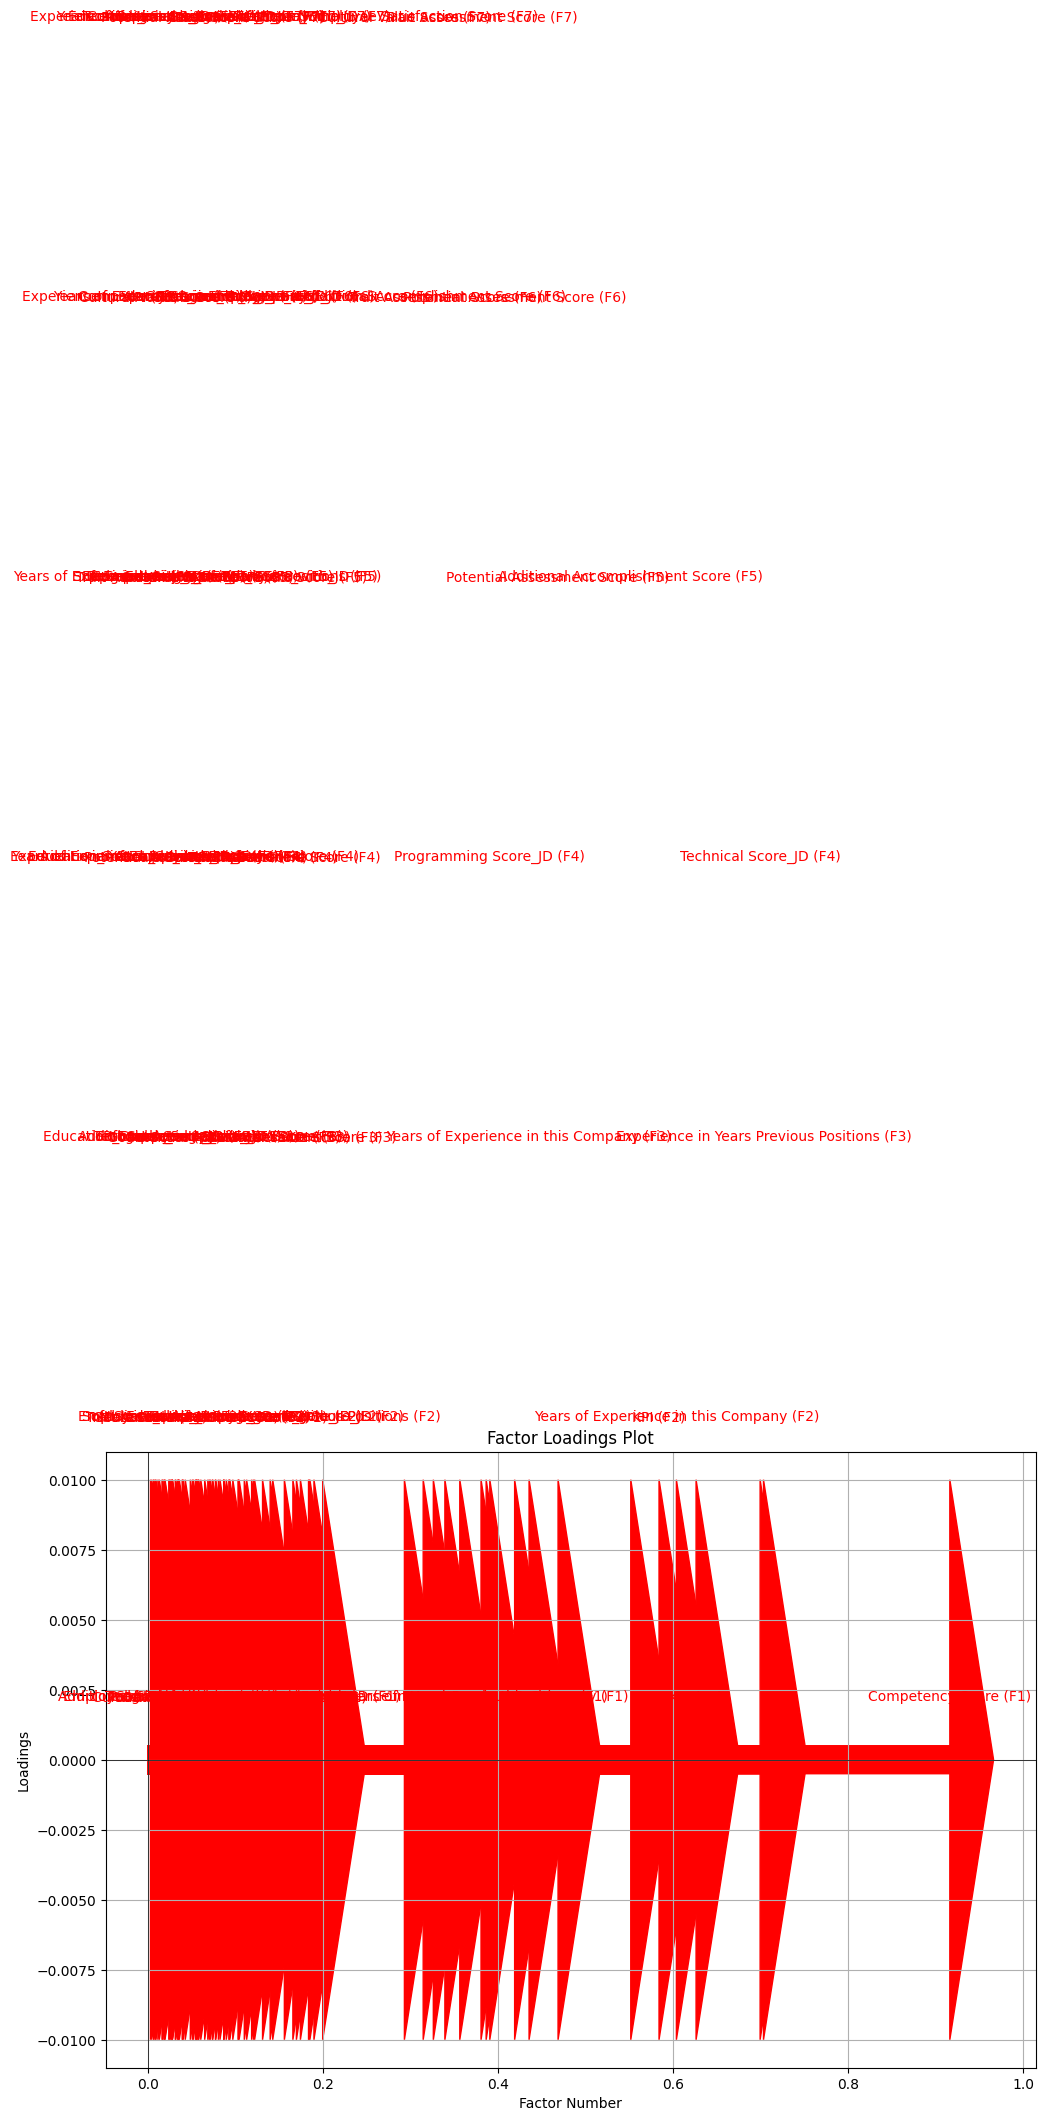

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def plot_factor_loadings(loadings, feature_names):
    num_factors = loadings.shape[1]
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    for i, feature in enumerate(feature_names):
        for j in range(num_factors):
            # Arrow from origin to the loading point
            ax.arrow(0, 0, loadings[i, j], 0, head_width=0.02, head_length=0.05, fc='r', ec='r')
            # Add text label slightly offset from the head of the arrow
            ax.text(loadings[i, j], 0.002 + 0.01 * j, f'{feature} (F{j+1})', color="red", ha='center', va='bottom')

    ax.set_xlabel('Factor Number')
    ax.set_ylabel('Loadings')
    ax.axhline(0, color='black', linewidth=0.5)  # Horizontal line at y=0
    ax.axvline(0, color='black', linewidth=0.5)  # Vertical line at x=0
    plt.grid(True)
    plt.title('Factor Loadings Plot')
    plt.show()

# Calling the function with the loadings and the feature names
plot_factor_loadings(factor_loadings, df_con.columns)
